# 1.Load dataset

In [59]:
! gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 28.2MB/s]


# 2.Import neccessary libraries

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 3.Set a fix random state

In [61]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# 4.Setup the computation device

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 5.Read dataset

In [63]:
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)

In [64]:
dataset.head()
dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Europe        392 non-null    int64  
 8   Japan         392 non-null    int64  
 9   USA           392 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 30.8 KB


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,0.173469,0.201531,0.625000
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.379136,0.401656,0.484742
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,0.000000,0.000000,0.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


# 6.Reprocessing data

In [65]:
# a) Get X features andy lable
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

In [66]:
# b) Divide dataset to sub-datasets: train, val, test

#train, val, test: 7:2:1
val_size = 0.2
test_size = 0.125
isshuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=isshuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.125, random_state=random_state, shuffle=isshuffle)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(273, 9)
(79, 9)
(40, 9)


In [67]:
# c) Standardize the input features
normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 7.Build DataLoader

In [68]:
# build PyTorch dataset class to store inputs, outputs
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# build DataLoader
batch_size = 32

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 8.Construct MLPs network

In [69]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        #x = F.tanh(x)
        x = self.linear2(x)
        x = F.relu(x)
        #x = F.tanh(x)
        out = self.output(x)
        return out.squeeze(1)

In [70]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

# 9.Declare loss and optimizer functions

In [71]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# 10.Build R2 score function

In [72]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)

    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)

    r2 = 1 - (ss_res / ss_tot)

    return r2

# 11.Train the MLP model

In [73]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []

    model.train()

    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        optimizer.zero_grad()
        outputs = model(X_samples)

        train_predict += outputs.tolist()
        train_target += y_samples.tolist()

        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()

    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)

            val_predict += outputs.tolist()
            val_target += y_samples.tolist()

            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))

    print(f'\nEPOCH {epoch+1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 282.769	Validation loss: 88.672

EPOCH 2:	Training loss: 137.669	Validation loss: 72.346

EPOCH 3:	Training loss: 71.007	Validation loss: 19.143

EPOCH 4:	Training loss: 25.083	Validation loss: 196.176

EPOCH 5:	Training loss: 96.139	Validation loss: 20.444

EPOCH 6:	Training loss: 17.765	Validation loss: 9.444

EPOCH 7:	Training loss: 18.486	Validation loss: 14.535

EPOCH 8:	Training loss: 37.859	Validation loss: 37.427

EPOCH 9:	Training loss: 17.133	Validation loss: 38.134

EPOCH 10:	Training loss: 22.991	Validation loss: 41.183

EPOCH 11:	Training loss: 26.723	Validation loss: 20.063

EPOCH 12:	Training loss: 9.852	Validation loss: 5.594

EPOCH 13:	Training loss: 15.143	Validation loss: 16.025

EPOCH 14:	Training loss: 12.213	Validation loss: 12.023

EPOCH 15:	Training loss: 14.222	Validation loss: 7.731

EPOCH 16:	Training loss: 10.845	Validation loss: 18.904

EPOCH 17:	Training loss: 12.312	Validation loss: 14.885

EPOCH 18:	Training loss: 15.474	Validati

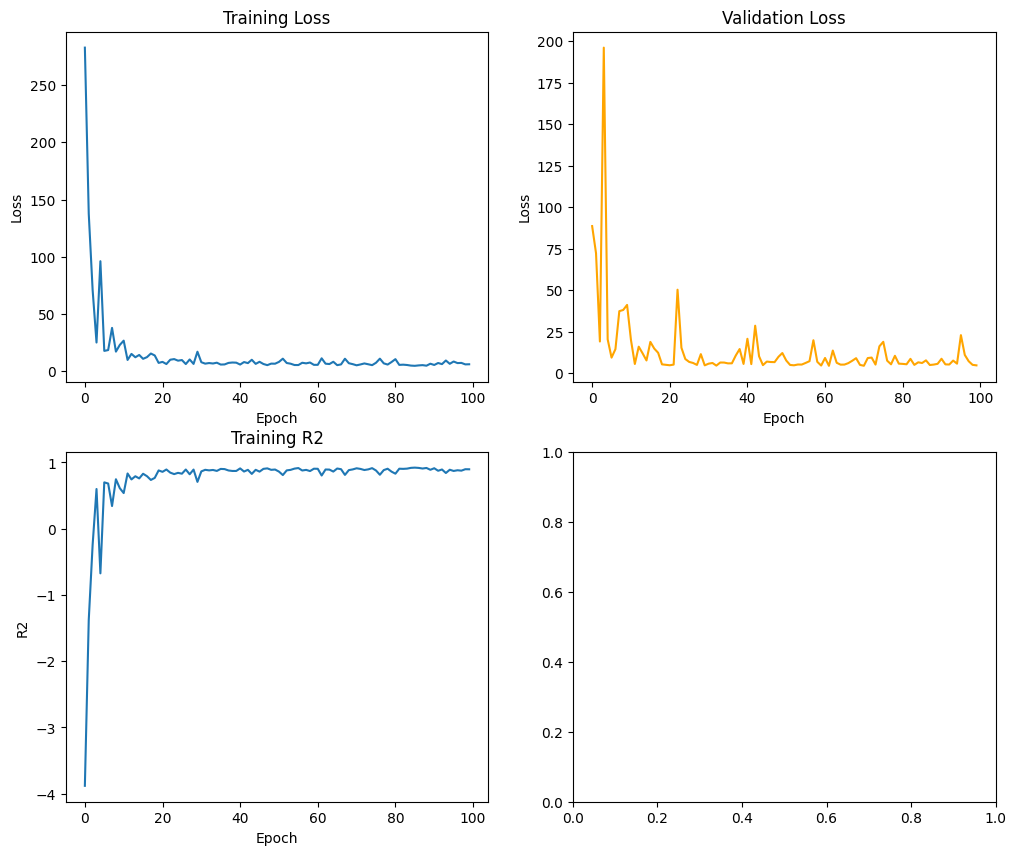

In [74]:
# data visualization
fig, ax = plt.subplots(2, 2, figsize = (12,10))

ax[0,0].plot(train_losses)
ax[0,0].set(xlabel='Epoch', ylabel='Loss')
ax[0,0].set_title('Training Loss')

ax[0,1].plot(val_losses, 'orange')
ax[0,1].set(xlabel='Epoch', ylabel='Loss')
ax[0,1].set_title('Validation Loss')

ax[1,0].plot(train_r2)
ax[1,0].set(xlabel='Epoch', ylabel='R2')
ax[1,0].set_title('Training R2')

plt.show()

# 12.Evaluate model on test dataset

In [75]:
model.eval()

with torch.no_grad():
    y_hat = model(X_test)
    test_set_r2 = r_squared(y_test ,y_hat)
    print('Evaluation on test set :')
    print(f'R2: {test_set_r2}')


Evaluation on test set :
R2: 0.8789367079734802
